## Purpose: Using Machine Learning, create a model that will attempt to determine if an employee is at risk for leaving the organization
## Authors: Group 6
## Date: June 1, 2022

### Import libraries


In [213]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# Customize notebook with jupyterthemes
from jupyterthemes import jtplot as jt
jt.style(theme = 'grade3', context = 'notebook', ticks = True, grid = False)
# Postgres DB connector
import psycopg2

### Read Data


In [214]:
# Password for Postgres DB
from config import postpw
# print(postpw)

In [215]:
# Connection String for the Postgress database - Replace yourPW with the password you used when you installed Postgres
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format('127.0.0.1', 5432, 'Group6Final', 'postgres', postpw))

In [216]:
SQL = """SELECT "Age",
"Attrition",
"BUSINESSTRAVEL",
"DailyRate",
"DEPARTMENT",
"DistanceFromHome",
"Education",
"EDUCATIONFIELD",
"EmployeeCount",
"EmployeeNumber",
"EnvironmentSatisfaction",
"GENDER",
"HourlyRate",
"JobInvolvement",
"JobLevel",
"JOBROLE",
"JobSatisfaction",
"MARITALSTATUS",
"MonthlyIncome",
"MonthlyRate",
"NumCompaniesWorked",
"Over18",
"OverTime",
"PercentSalaryHike",
"PerformanceRating",
"RelationshipSatisfaction",
"StandardHours",
"StockOptionLevel",
"TotalWorkingYears",
"TrainingTimesLastYear",
"WorkLifeBalance",
"YearsAtCompany",
"YearsInCurrentRole",
"YearsSinceLastPromotion",
"YearsWithCurrManager",
"NumberProjects",
"WorkplaceAccident"
FROM "Employee_Status" AS ES
JOIN "CD_TRAVEL" CDT ON ES."BusinessTravel_FK" = CDT."BUSINESSTRAVEL_FK"
JOIN "CD_DEPARTMENT" CDD ON ES."Department_FK" = CDD."DEPARTMENT_FK"
JOIN "CD_EDUCATIONFIELD" CDE ON ES."EducationField_FK" = CDE."EDUCATIONFIELD_FK"
JOIN "CD_GENDER" CDG ON ES."Gender_FK" = CDG."GENDER_FK"
JOIN "CD_ROLE" CDR ON ES."JobRole_FK" = CDR."JOBROLE_FK"
JOIN "CD_M_STATUS" CDS ON ES."MaritalStatus_FK" = CDS."MARITALSTATUS_FK""" + '"'

In [217]:
# Need to add the double quotes back in at the end
SQL 

'SELECT "Age",\n"Attrition",\n"BUSINESSTRAVEL",\n"DailyRate",\n"DEPARTMENT",\n"DistanceFromHome",\n"Education",\n"EDUCATIONFIELD",\n"EmployeeCount",\n"EmployeeNumber",\n"EnvironmentSatisfaction",\n"GENDER",\n"HourlyRate",\n"JobInvolvement",\n"JobLevel",\n"JOBROLE",\n"JobSatisfaction",\n"MARITALSTATUS",\n"MonthlyIncome",\n"MonthlyRate",\n"NumCompaniesWorked",\n"Over18",\n"OverTime",\n"PercentSalaryHike",\n"PerformanceRating",\n"RelationshipSatisfaction",\n"StandardHours",\n"StockOptionLevel",\n"TotalWorkingYears",\n"TrainingTimesLastYear",\n"WorkLifeBalance",\n"YearsAtCompany",\n"YearsInCurrentRole",\n"YearsSinceLastPromotion",\n"YearsWithCurrManager",\n"NumberProjects",\n"WorkplaceAccident"\nFROM "Employee_Status" AS ES\nJOIN "CD_TRAVEL" CDT ON ES."BusinessTravel_FK" = CDT."BUSINESSTRAVEL_FK"\nJOIN "CD_DEPARTMENT" CDD ON ES."Department_FK" = CDD."DEPARTMENT_FK"\nJOIN "CD_EDUCATIONFIELD" CDE ON ES."EducationField_FK" = CDE."EDUCATIONFIELD_FK"\nJOIN "CD_GENDER" CDG ON ES."Gender_FK" = CD

In [218]:
# Read the file into a dataframe
hr_df = pd.read_sql_query(SQL, conn)
hr_df_copy = hr_df 

### Initial Analysis
- Any missing elements that need to be fixed
- Fix data issues


In [219]:
# Check the data and column names
hr_df.head()

,Age,Attrition,BUSINESSTRAVEL,DailyRate,DEPARTMENT,DistanceFromHome,Education,EDUCATIONFIELD,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,GENDER,HourlyRate,JobInvolvement,JobLevel,JOBROLE,JobSatisfaction,MARITALSTATUS,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,2,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,5,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,7,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,5,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,2,0


In [220]:
# Rename column names so they are all consistent
hr_df.rename(columns = {'BUSINESSTRAVEL':'BusinessTravel','DEPARTMENT':'Department','EDUCATIONFIELD':'EducationField','GENDER':'Gender','JOBROLE':'JobRole','MARITALSTATUS':'MaritalStatus' }, inplace = True)

In [221]:
# Verify the rename 
hr_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'NumberProjects', 'WorkplaceAccident'],
      dtype='object')

In [222]:
# Check number of rows/columns
hr_df.shape

(1470, 37)

In [223]:
# Check for null values
hr_df.isnull().values.any()

False

In [224]:
# Another method to check for null values
hr_df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [225]:
# Another check for null values
hr_df.isnull()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1466,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1467,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1468,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [226]:
# Count of unique values in each column
hr_df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [227]:
# Appears that columns EmployeeCount, Over18 and StandardHours all contain only 1 value
# Also, the EmployeeNumber is just an ID so it can be dropped

In [228]:
# Before we drop verify EmployeeCount values are the same for all employees
print(hr_df['EmployeeCount'].nunique())
print(hr_df['EmployeeCount'].unique())

1
[1]


In [229]:
# Before we drop verify Over18 values are the same for all employees
print(hr_df['Over18'].nunique())
print(hr_df['Over18'].nunique())

1
1


In [230]:
# Before we drop verify StandardHours values are the same for all employees
print(hr_df['StandardHours'].nunique())
print(hr_df['StandardHours'].unique())

1
[80]


In [231]:
hr_df = hr_df.drop(columns=['EmployeeNumber','EmployeeCount','Over18','StandardHours'])

In [232]:
# Verify 4 columns dropped
hr_df.shape

(1470, 33)

### Exploratory Phase
- Get data statistics 
- Visualize the data

In [233]:
# determine data types by column
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [234]:
# Which columns are considered numeric, we need to exclude them later for the one hot encoding
hr_df.select_dtypes(include='int64').columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident'],
      dtype='object')

In [235]:
# Which columns are considered categorical, we need this info later for the encoding
hr_df.select_dtypes(include='object').columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')

In [236]:
# How manu numerical features
len(hr_df.select_dtypes(include='int64').columns)

25

In [237]:
# get df stats
hr_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,3.890476,0.051701
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,1.810522,0.221497
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,4.000000,0.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,6.000000,0.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,7.000000,1.000000


In [238]:
# see all the columns with descriptive stats
pd.set_option('display.max_columns', None)
hr_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,3.890476,0.051701
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,1.810522,0.221497
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,4.000000,0.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,6.000000,0.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,7.000000,1.000000


In [239]:
# random sample of the df
hr_df.sample(7)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident
634,25,No,Travel_Rarely,141,Sales,3,1,Other,3,Male,98,3,2,Sales Executive,1,Married,4194,14363,1,Yes,18,3,4,0,5,3,3,5,3,0,3,5,0
1412,30,No,Travel_Rarely,911,Research & Development,1,2,Medical,4,Male,76,3,1,Laboratory Technician,2,Married,3748,4077,1,No,13,3,3,0,12,6,2,12,8,1,7,2,0
440,34,Yes,Travel_Frequently,988,Human Resources,23,3,Human Resources,2,Female,43,3,3,Human Resources,1,Divorced,9950,11533,9,Yes,15,3,3,3,11,2,3,3,2,0,2,2,0
934,25,No,Travel_Rarely,266,Research & Development,1,3,Medical,4,Female,40,3,1,Research Scientist,2,Single,2096,18830,1,No,18,3,4,0,2,3,2,2,2,2,1,6,0
1327,46,No,Travel_Rarely,1319,Sales,3,3,Technical Degree,1,Female,45,4,4,Sales Executive,1,Divorced,13225,7739,2,No,12,3,4,1,25,5,3,19,17,2,8,2,0
1359,34,No,Travel_Rarely,735,Sales,3,1,Medical,4,Female,75,2,2,Sales Executive,4,Married,8103,16495,3,Yes,12,3,3,0,9,3,2,4,2,0,1,2,0
633,36,No,Travel_Rarely,1278,Human Resources,8,3,Life Sciences,1,Male,77,2,1,Human Resources,1,Married,2342,8635,0,No,21,4,3,0,6,3,3,5,4,0,3,2,0


<AxesSubplot:xlabel='Education', ylabel='DailyRate'>

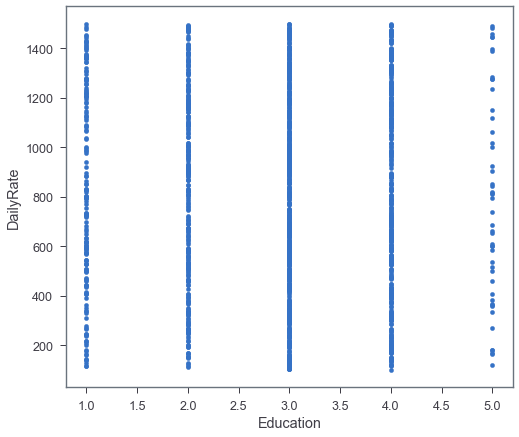

In [240]:
# look at running_time vs runtime using a scatter plot
hr_df.plot(x='Education', y='DailyRate', kind='scatter', color = 'b')

In [241]:
# Get a count of the target variable values
print("Count of Employees who stayed: ", (hr_df.Attrition == 'No').sum())
print("Count of Employees who left: ", (hr_df.Attrition == 'Yes').sum())

Count of Employees who stayed:  1233
Count of Employees who left:  237


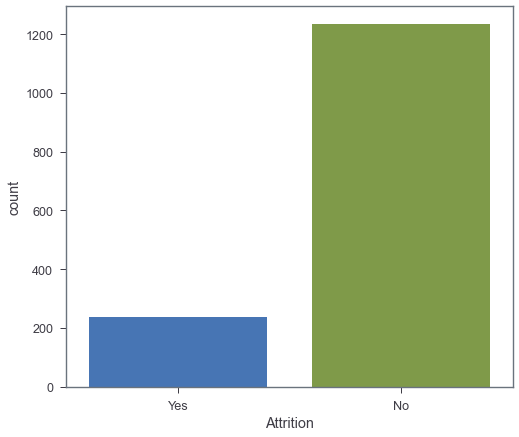

In [242]:
# Plot the target variable, how many instances of each value
sns.countplot(x=hr_df['Attrition'])
plt.show()

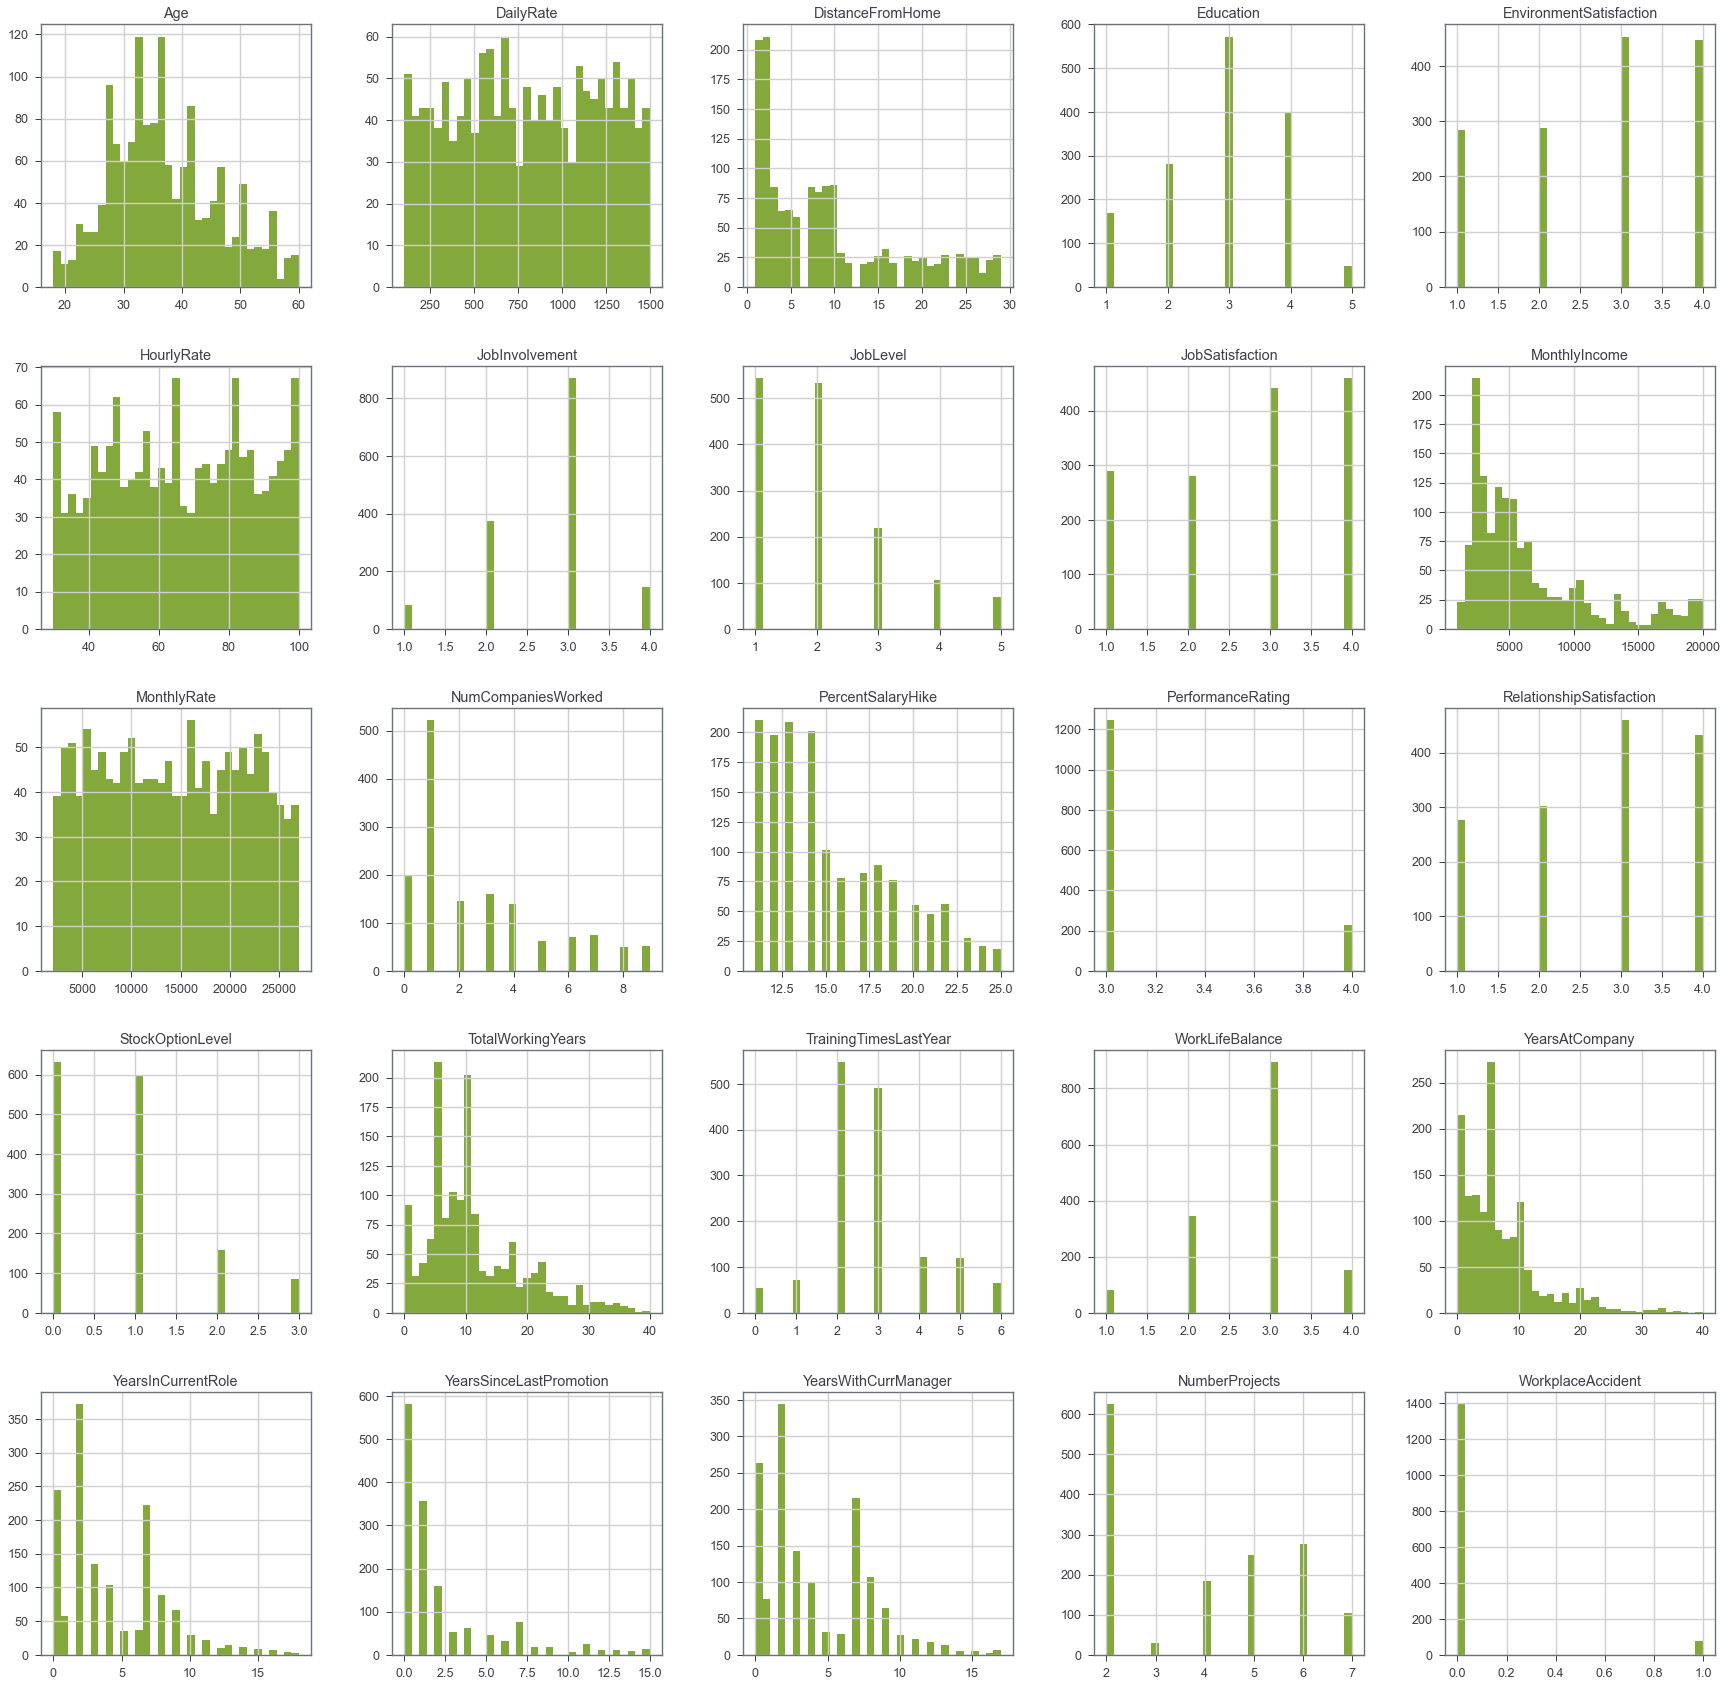

In [243]:
# Examine the distribution of the numerical features
hr_df.hist(bins = 33, figsize = (30,30), color = 'g');

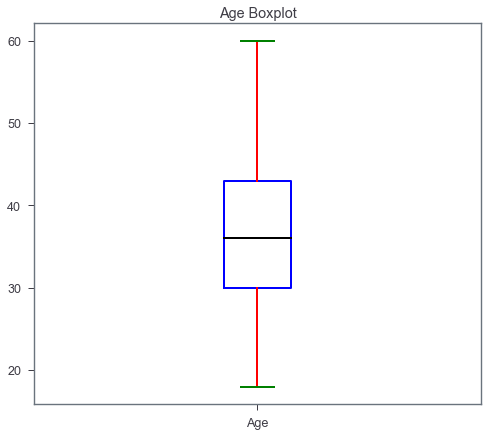

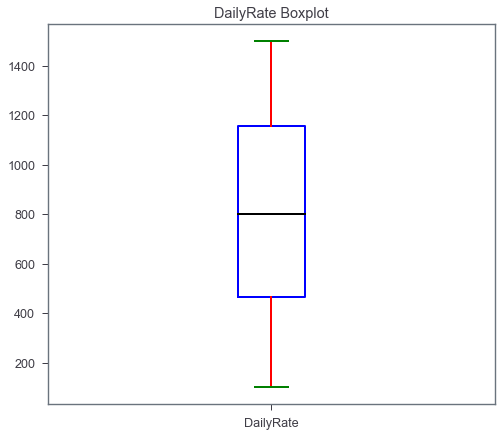

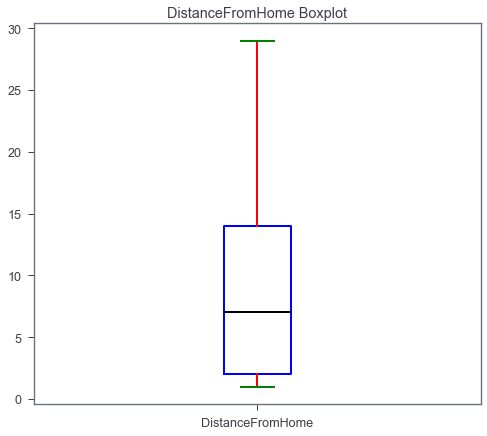

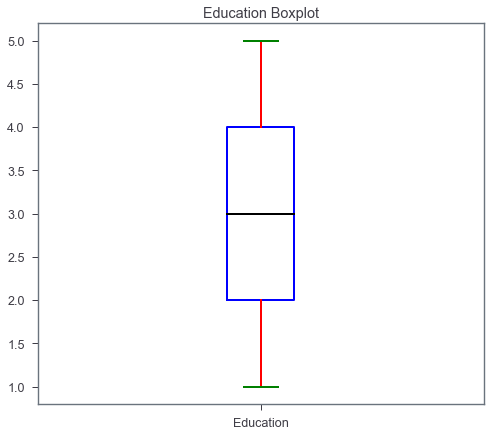

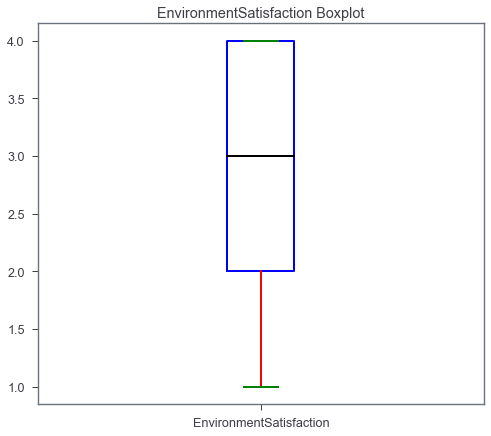

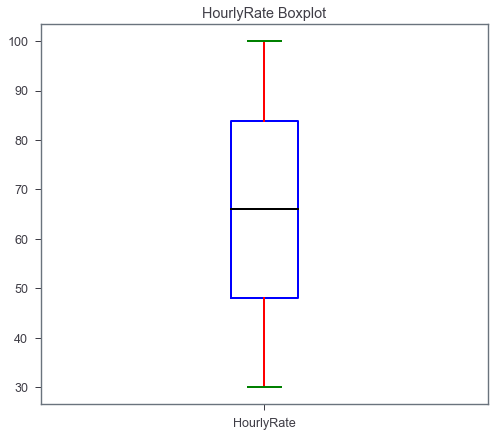

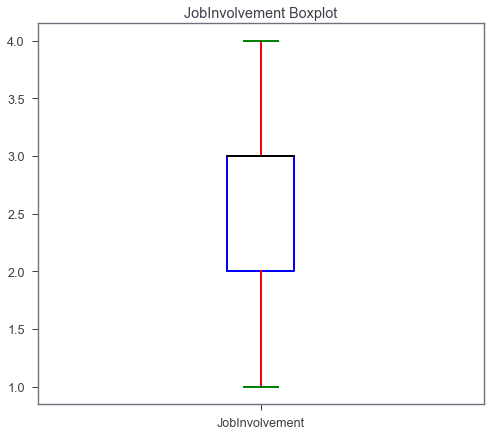

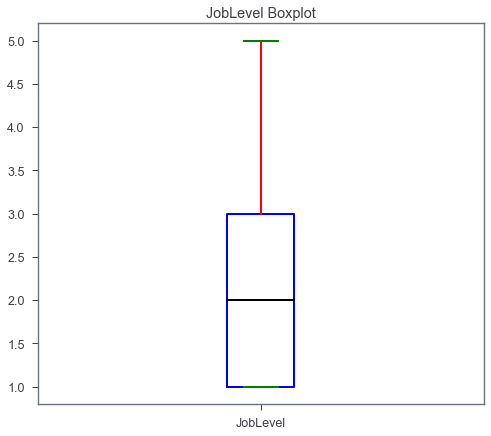

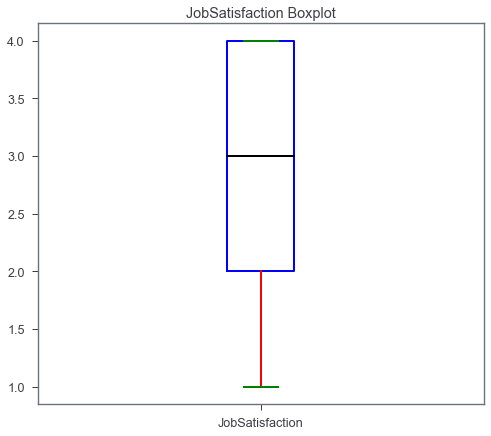

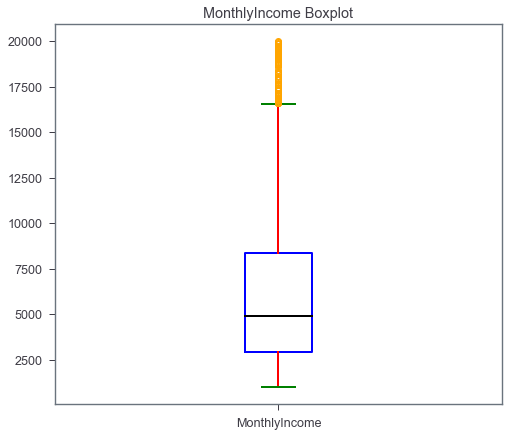

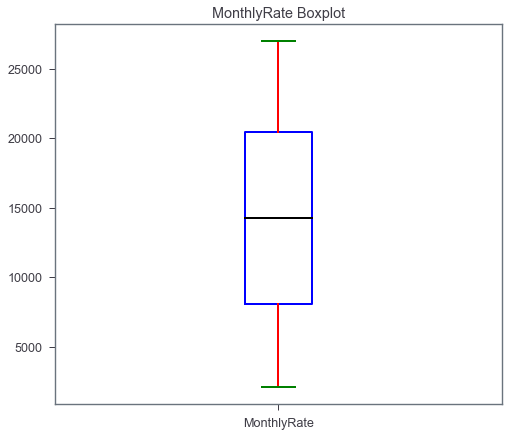

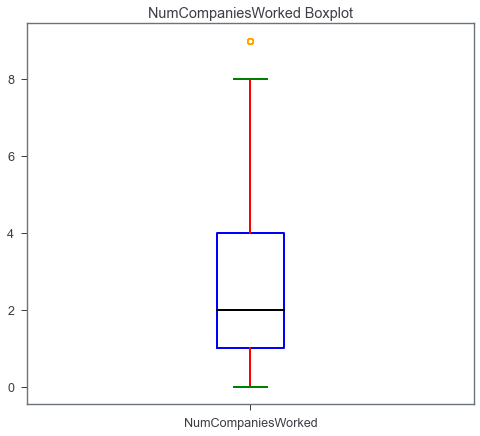

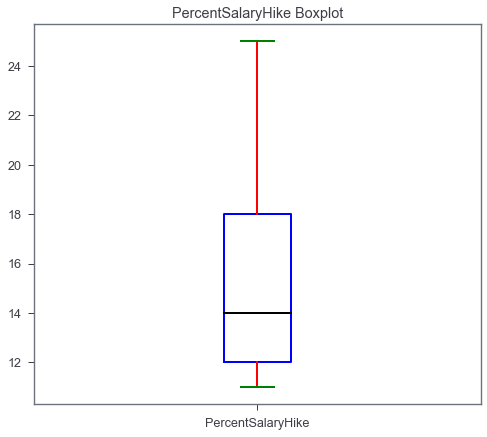

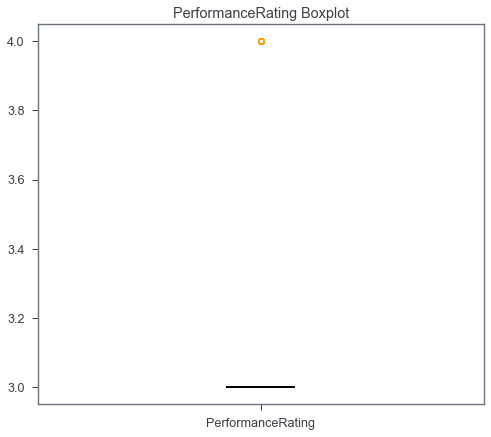

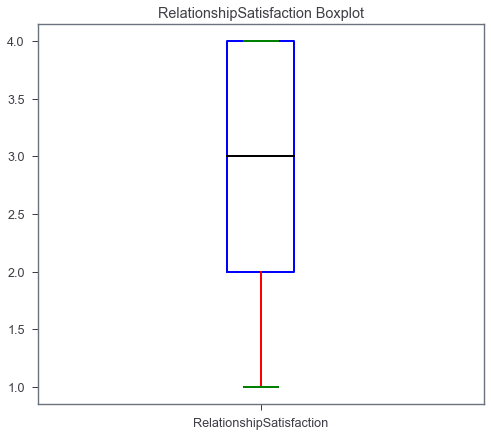

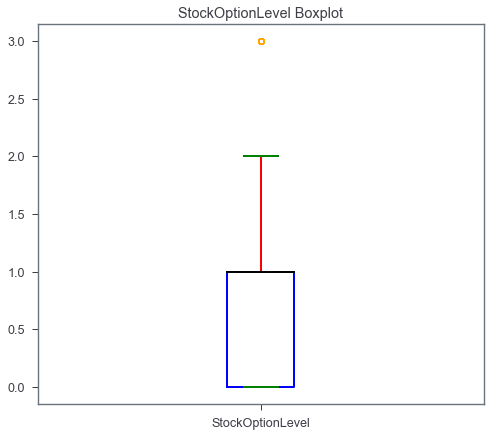

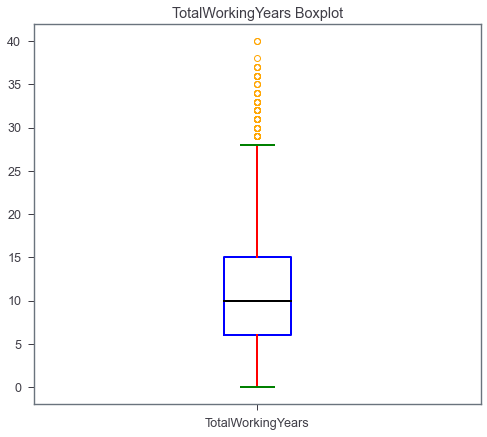

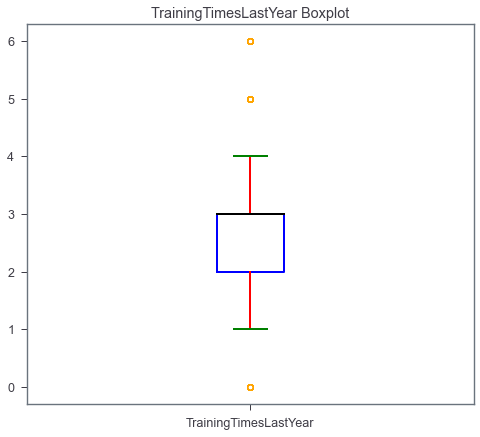

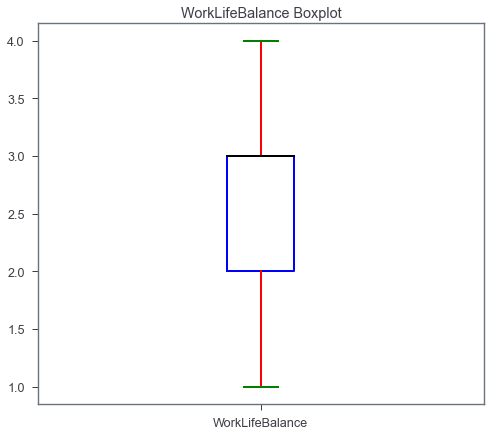

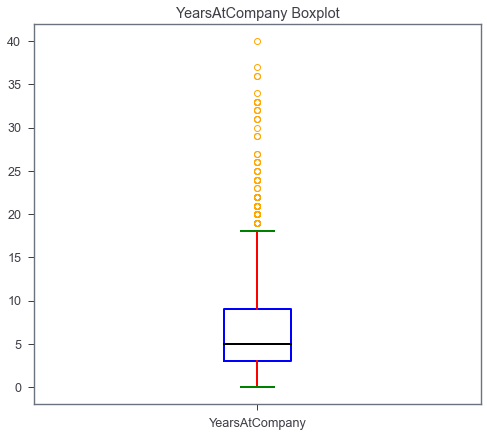

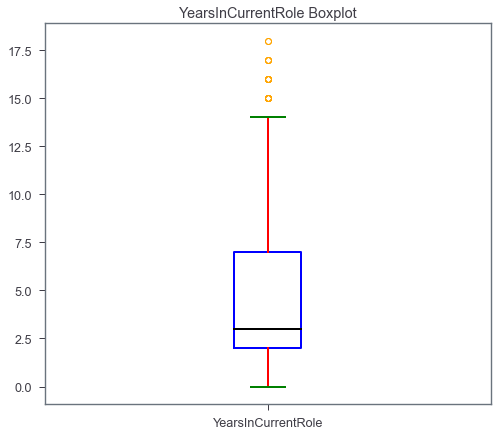

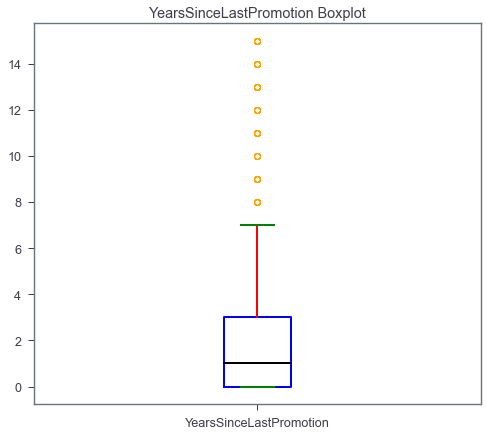

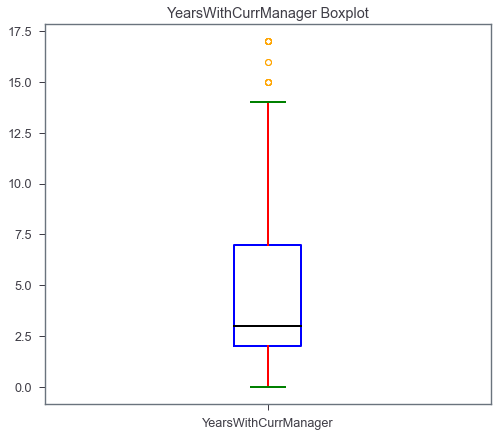

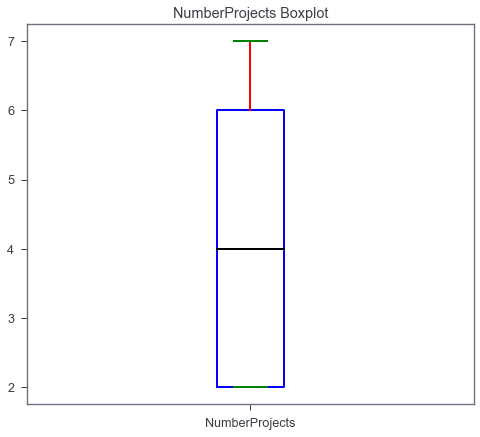

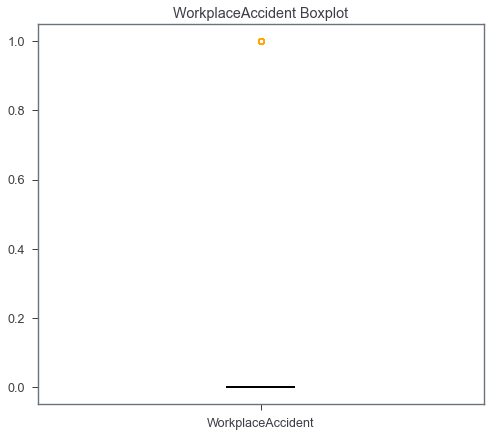

In [245]:
# Examine the distribution of the numerical features usig a boxplot
col_names = hr_df.select_dtypes(include='int64').columns
BP_color = 'blue'
W_color = 'red'
M_color = 'black'
C_color = 'green'
F_color = 'orange'

for col in col_names:
    hr_df[col].plot(kind='box', title = col + ' Boxplot',
            boxprops=dict(linewidth=2, color=BP_color),
            capprops=dict(linewidth=2, color=C_color),
            whiskerprops=dict(linewidth=2, color=W_color),
            flierprops=dict(color=F_color, markeredgecolor=F_color),
            medianprops=dict(linewidth=2, color=M_color))
    plt.show()

In [246]:
hr_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident'],
      dtype='object')

<AxesSubplot:xlabel='Department', ylabel='count'>

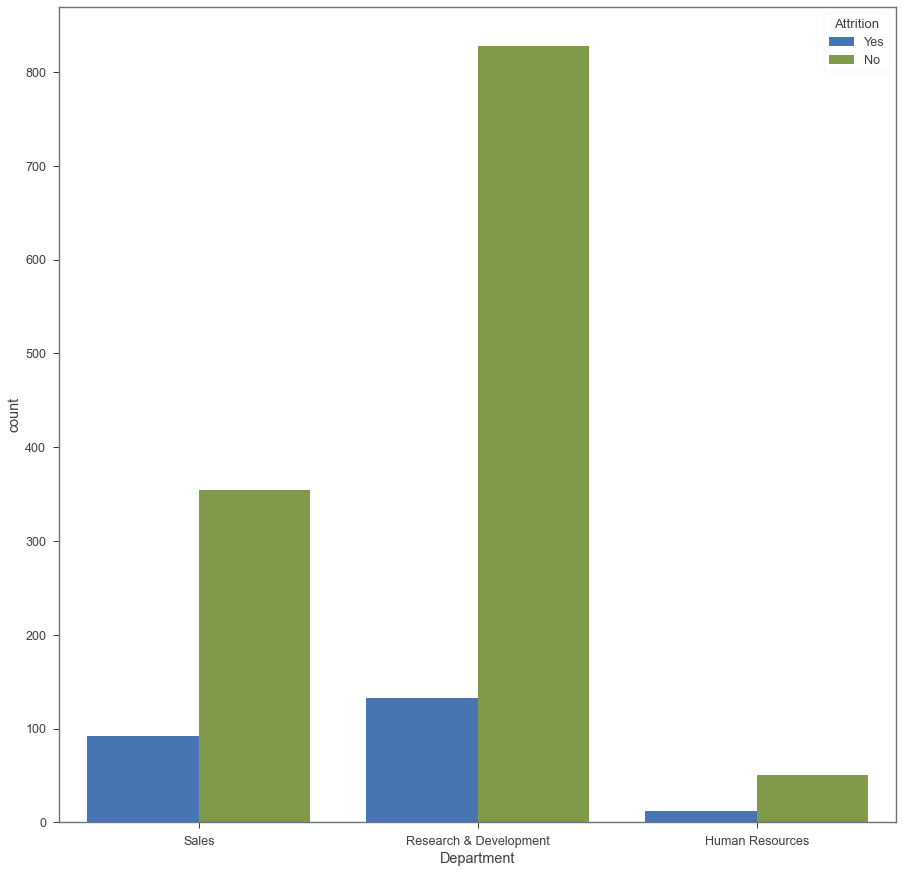

In [247]:
plt.figure(figsize=[15,15])
plt.subplot(111)
sns.countplot(x = 'Department', hue = 'Attrition', data = hr_df)

<AxesSubplot:xlabel='NumberProjects', ylabel='count'>

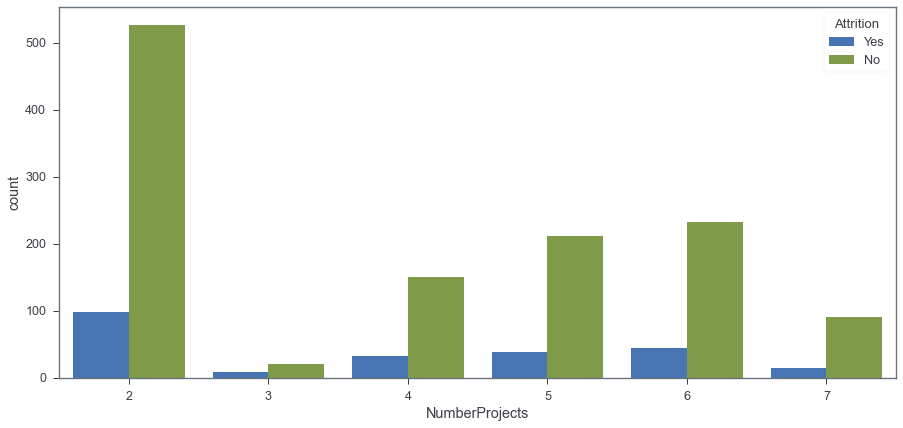

In [248]:
plt.figure(figsize=[15,15])
plt.subplot(211)
sns.countplot(x = 'NumberProjects', hue = 'Attrition', data = hr_df)

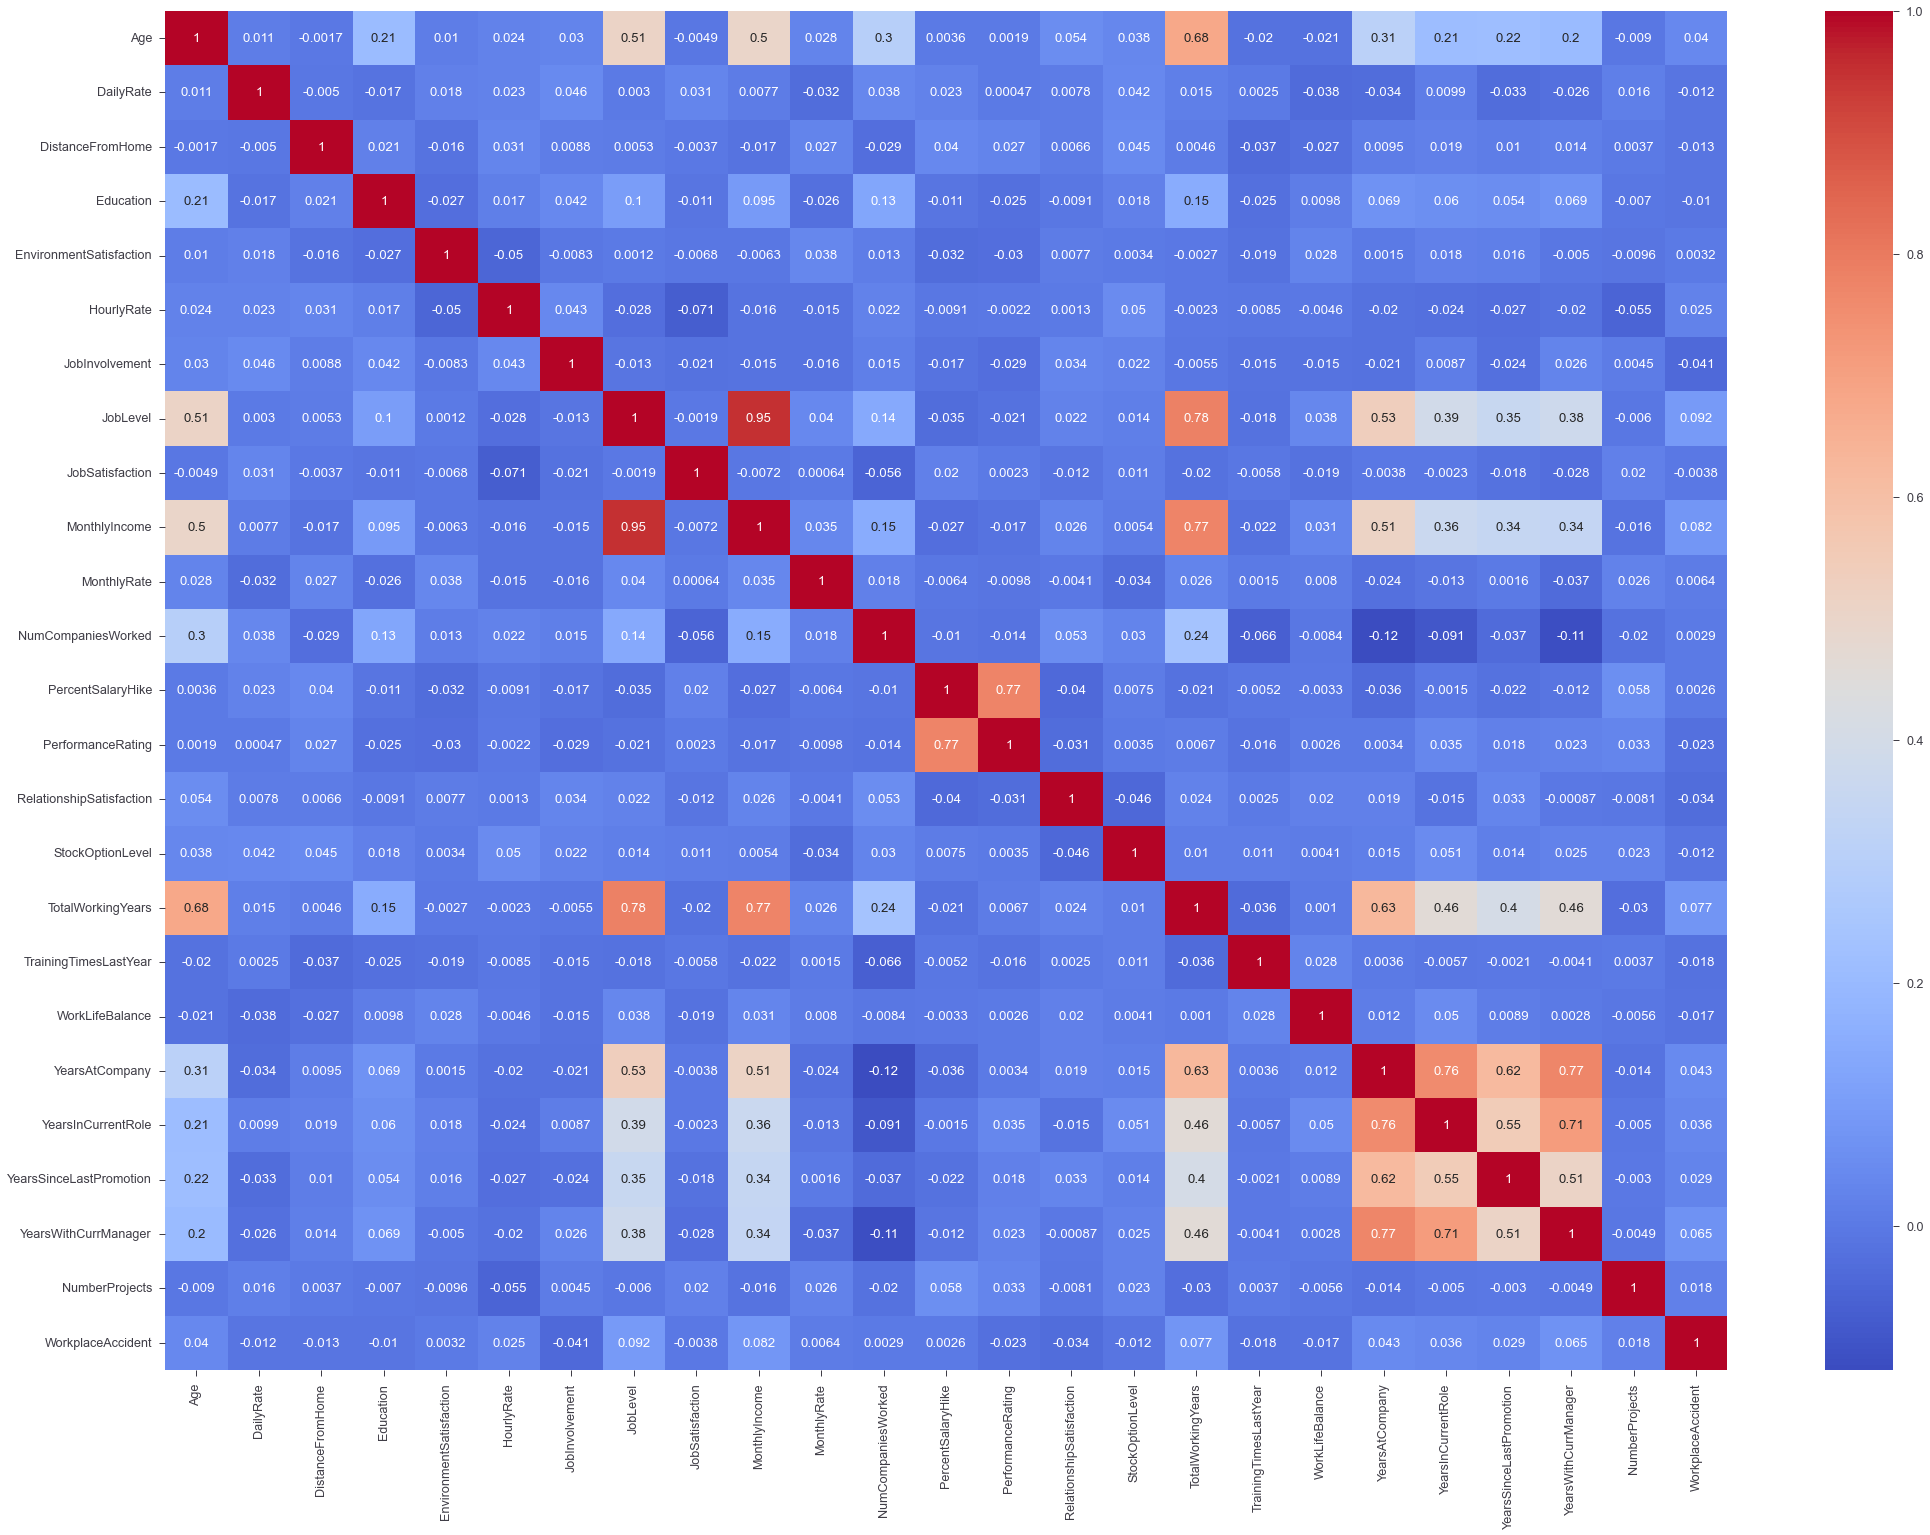

In [249]:
import seaborn as sns
# Examine correlations between features
correlation_matrix = hr_df.corr()
plt.figure(figsize=(35, 25))
heat_map = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm' )

### Transform Phase
- One hot encoding
- Reduction/Scaling


In [250]:
# Before OneHotEncoder check the number of rows and columns
hr_df.shape

(1470, 33)

In [251]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
#generate categorical variable list
hr_cat = hr_df.dtypes[hr_df.dtypes == "object"].index.tolist()

# check unique values
print(hr_df[hr_cat].nunique())

enc = OneHotEncoder(sparse=False)

#fit/transform
hr_encode = pd.DataFrame(enc.fit_transform(hr_df[hr_cat]))

# add names to df
hr_encode.columns = enc.get_feature_names_out(hr_cat)

# look at it
hr_encode.head()

Attrition         2
BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
OverTime          2
dtype: int64


,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [252]:
# merge/drop originals

hr_df = hr_df.merge(hr_encode, left_index=True, right_index=True)
hr_df = hr_df.drop(hr_cat, 1)

hr_df.head()

D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,5,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,7,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,5,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,2,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [253]:
hr_df.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumberProjects',
       'WorkplaceAccident', 'Attrition_No', 'Attrition_Yes',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 

In [254]:
# After OneHotEncoder check the number of rows and columns and the length, which should be 0
#   if all categorical columns are encoded
print(hr_df.shape)
print(len(hr_df.select_dtypes(include = "object").columns))

(1470, 55)
0


In [255]:
# split data into feature/target
y = hr_df['Attrition_Yes'].values
# X = hr_df.drop(['Attrition_Yes', 'Attrition_No'], 1)
X = hr_df.drop(columns=['Attrition_Yes', 'Attrition_No'])
X.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,7,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [256]:
print(y)

[1. 0. 1. ... 0. 0. 0.]


In [257]:
# Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=78)

In [258]:
print("X_train {}".format(X_train.shape))
print("X_test {}".format(X_test.shape))
print("y_train {}".format(y_train.shape))
print("y_test {}".format(y_test.shape))

X_train (1176, 53)
X_test (294, 53)
y_train (1176,)
y_test (294,)


In [259]:
# Reduction/Scaling

from sklearn.preprocessing import StandardScaler ##?? MIN MAX SCALER?
# Create instance
scaler = StandardScaler()

# Fit 
X_scaler = scaler.fit(X_train)

# Scale 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [260]:
X_train_scaled

array([[ 3.57156995e-01, -1.32052987e-01,  3.77850497e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-8.64144324e-01,  4.76963816e-01, -8.79868677e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-7.53116932e-01,  1.08598062e+00,  5.34744547e-04, ...,
        -6.84225689e-01, -1.59107873e+00,  1.59107873e+00],
       ...,
       [-1.97979968e-01, -8.42986888e-01, -6.28324842e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-1.41928129e+00, -6.66496304e-01,  1.88711351e+00, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-6.42089539e-01, -1.16365288e+00,  5.34744547e-04, ...,
         1.46150607e+00, -1.59107873e+00,  1.59107873e+00]])

In [261]:
X_test_scaled

array([[ 1.35102210e-01,  1.71985525e+00,  1.26306662e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [-8.64144324e-01, -9.00159894e-01, -1.25237173e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       [ 5.79211781e-01,  1.66765381e+00, -5.02552925e-01, ...,
        -6.84225689e-01,  6.28504410e-01, -6.28504410e-01],
       ...,
       [ 2.46667746e+00,  1.57070828e+00,  2.01288542e+00, ...,
         1.46150607e+00,  6.28504410e-01, -6.28504410e-01],
       [ 1.91154049e+00,  4.17305027e-01, -1.00564059e+00, ...,
         1.46150607e+00,  6.28504410e-01, -6.28504410e-01],
       [-3.09007361e-01,  1.58810876e+00,  5.34744547e-04, ...,
         1.46150607e+00,  6.28504410e-01, -6.28504410e-01]])

## Plan: Build 5 models and compare which is the most accurate. On the most accurate model perform hyperparameter tuning to see if any performance improvement can be made. The 5 models that will be built and tested are:

## Logistical Regression 
## Random Forest
## Support Vector Machine
## XGBoost
## Naive Bayes



## Model 1: Logistical Regression



### Build Model



In [262]:
# Import
from sklearn.linear_model import LogisticRegression

# create model
# By upping the max_iter parm to 10000 finally was able to get rid of warning, model performance also improved
LR_classifier = LogisticRegression(max_iter=10000, random_state=0)

# fit model
LR_classifier.fit(X_train_scaled, y_train)

# validate model
print(f"Training Data Score: {LR_classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {LR_classifier.score(X_test_scaled, y_test)}")

# create predictions
LR_pred = LR_classifier.predict(X_test_scaled)


Training Data Score: 0.8971088435374149
Testing Data Score: 0.8979591836734694



### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [263]:
# Import
from sklearn.metrics import accuracy_score

LR_acc_score = accuracy_score(y_test,LR_pred)
print("LR Accuracy Score = {0:.5g}%".format(LR_acc_score * 100))

LR Accuracy Score = 89.796%


In [264]:
# Import and create confusion matrix
from sklearn.metrics import confusion_matrix

LR_confusion_matrix = confusion_matrix(y_test, LR_pred)
print("LR Confusion Matrix \n {}".format(LR_confusion_matrix))

LR Confusion Matrix 
 [[247   5]
 [ 25  17]]


In [265]:
# Alternate method to create confusion matrix
balanced_accuracy_score(y_test, LR_pred)

LR_CM = confusion_matrix(y_test, LR_pred)

LR_cm_df = pd.DataFrame(
    LR_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

LR_cm_df.head()


,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,247,5
Actual_low_risk,25,17


In [266]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, LR_pred))


                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.91      0.98      0.40      0.94      0.63      0.42       252
        1.0       0.77      0.40      0.98      0.53      0.63      0.37        42

avg / total       0.89      0.90      0.49      0.88      0.63      0.41       294



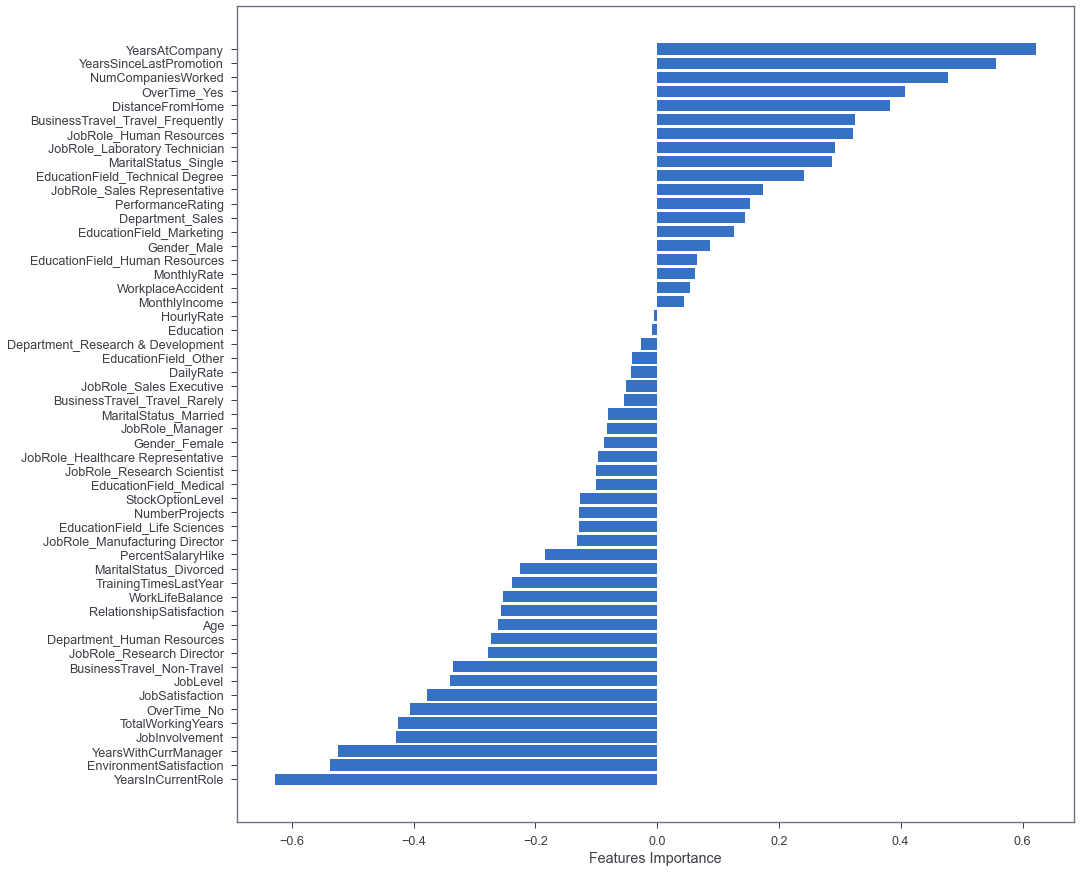

In [267]:
# List the importance of features in predicting the target variable, Attrition.

feature_names = X.columns
features = np.array(feature_names)

LR_importance = LR_classifier.coef_[0]
LR_importances = pd.Series(LR_importance, index=features)

LR_feat_sorted = LR_importances.argsort()

plt.figure(figsize=[15, 15])
plt.barh(features[LR_feat_sorted], LR_importances[LR_feat_sorted])
plt.xlabel("Features Importance")
plt.show()

In [268]:
# What are the Top 10 features in importance for the model, ranked from most important to least
LR_feat_importance = pd.Series(LR_importance)

feature_names = X.columns
df_feature_names = pd.DataFrame({'features':feature_names})
print(df_feature_names.loc[LR_feat_importance.nlargest(10).index, "features"])

19                      YearsAtCompany
21             YearsSinceLastPromotion
11                  NumCompaniesWorked
52                        OverTime_Yes
2                     DistanceFromHome
26    BusinessTravel_Travel_Frequently
40             JobRole_Human Resources
41       JobRole_Laboratory Technician
50                MaritalStatus_Single
36     EducationField_Technical Degree
Name: features, dtype: object



### Test Models
- Assess classification model accuracy


In [269]:
X.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,7,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,5,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [270]:
from random import randint
rand_num = randint(0, len(X))

In [271]:
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]

In [272]:
single_observation

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumberProjects,WorkplaceAccident,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
952,31,1060,1,3,4,54,3,1,2,2302,8319,1,11,3,1,0,3,2,4,3,2,2,2,6,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [273]:
# Spot check the model by making a single prediction
print("This is a prediction using the LR classifier from a single observation at row {} {}".format(rand_num, LR_classifier.predict(scaler.transform(single_observation))))
print("The actual value in the dataframe at row is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the database is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

This is a prediction using the LR classifier from a single observation at row 952 [1.]
The actual value in the dataframe at row is 952    1.0
Name: Attrition_Yes, dtype: float64 
The actual value in the database is 952    Yes
Name: Attrition, dtype: object 



## Model 2: Random Forest



### Build Model



In [274]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit
rf_classifier.fit(X_train_scaled, y_train)

rf_pred = rf_classifier.predict(X_test_scaled)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [275]:
rf_acc_score = accuracy_score(y_test,rf_pred)
print("RF Accuracy Score = {0:.5g}%".format(rf_acc_score * 100))

RF Accuracy Score = 86.735%


In [276]:
rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
print("RF Confusion Matrix \n {}".format(rf_confusion_matrix))

RF Confusion Matrix 
 [[251   1]
 [ 38   4]]


In [277]:
balanced_accuracy_score(y_test, rf_pred)

RF_CM = confusion_matrix(y_test, rf_pred)

RF_cm_df = pd.DataFrame(
    RF_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

RF_cm_df.head()


,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,251,1
Actual_low_risk,38,4


In [278]:
# Calculated the balanced accuracy score
rf_pred = rf_classifier.predict(X_test_scaled)
balanced_accuracy_score(y_test, rf_pred)

# Display the confusion matrix
cm = confusion_matrix(y_test, rf_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)


# Print the imbalanced classification report

print(classification_report_imbalanced(y_test, rf_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.87      1.00      0.10      0.93      0.31      0.10       252
        1.0       0.80      0.10      1.00      0.17      0.31      0.09        42

avg / total       0.86      0.87      0.22      0.82      0.31      0.10       294



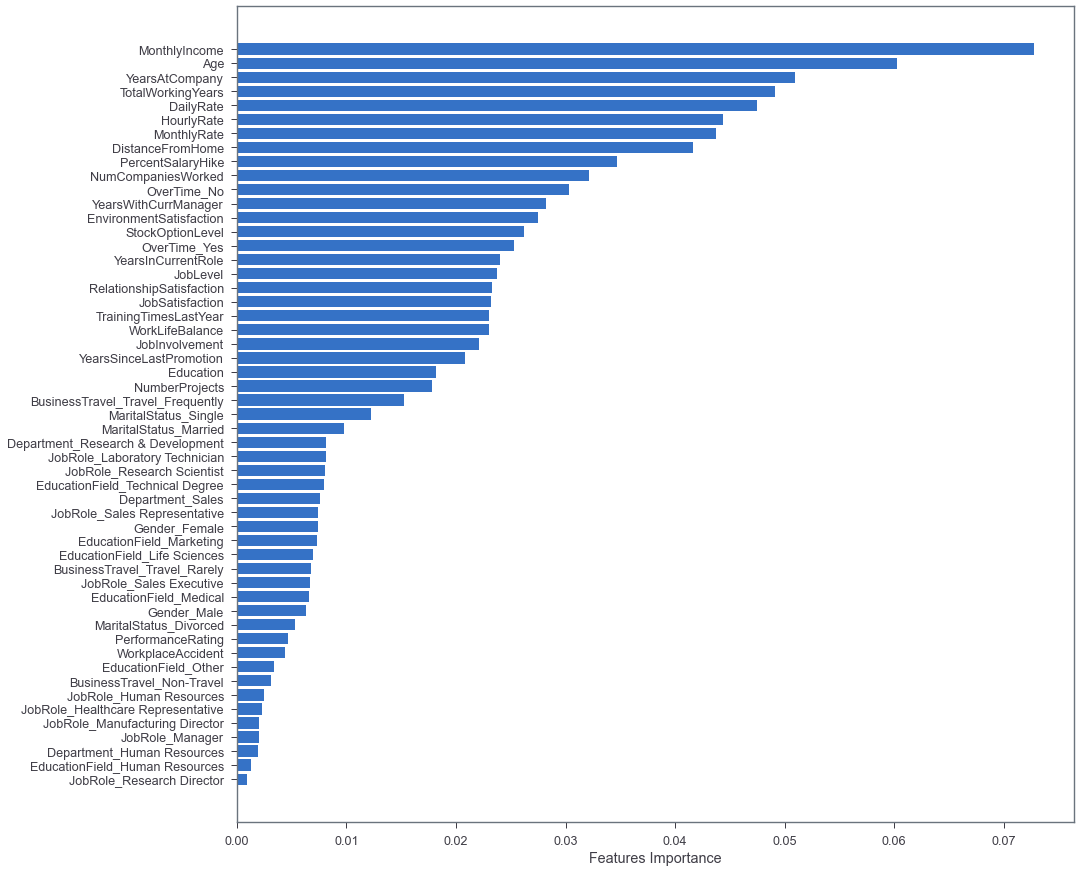

In [279]:
# List the importance of features in predicting the target variable, Attrition.

RF_importances = rf_classifier.feature_importances_

features = np.array(feature_names)
forest_importances = pd.Series(RF_importances, index=features)

feat_sorted = forest_importances.argsort()

plt.figure(figsize=[15, 15])
plt.barh(features[feat_sorted], forest_importances[feat_sorted])
plt.xlabel("Features Importance")
plt.show()

In [280]:
# Top 10 features affecting model 

RF_feat_importance = pd.Series(RF_importances)
df_feature_names = pd.DataFrame({'features':feature_names})
print(df_feature_names.loc[RF_feat_importance.nlargest(10).index, "features"])

9          MonthlyIncome
0                    Age
19        YearsAtCompany
16     TotalWorkingYears
1              DailyRate
5             HourlyRate
10           MonthlyRate
2       DistanceFromHome
12     PercentSalaryHike
11    NumCompaniesWorked
Name: features, dtype: object



### Test Models
- Assess classification model accuracy


In [281]:
# Spot chexk the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]
# Spot xhexk the model by making a single prediction
print("Make a prediction using the RF classifier from a single observation at row {} {}".format(rand_num, rf_classifier.predict(scaler.transform(single_observation))))
print("The actual value in the dataframe at row is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the database is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the RF classifier from a single observation at row 465 [0.]
The actual value in the dataframe at row is 465    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the database is 465    No
Name: Attrition, dtype: object 



## Model 3: Support Vector Machine



### Build Model



In [282]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm
# Kernel can have values of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable.
# linear gives the exact same accuracy as the linear regression classifier, rbf (Radial Basis Function(RBF)) is the next most accurate and poly the least
from sklearn.svm import SVC

svc_classifier = SVC(kernel='rbf', C=2, random_state=44)
svc_classifier.fit(X_train_scaled, y_train)

SVC(C=2, random_state=44)

In [283]:
# Make the predictions
svc_pred = svc_classifier.predict(X_test_scaled)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [284]:
svc_acc_score = accuracy_score(y_test,svc_pred)
print("SVC Accuracy Score = {0:.5g}%".format(svc_acc_score * 100))

SVC Accuracy Score = 89.116%


In [285]:
svc_confusion_matrix = confusion_matrix(y_test, svc_pred)
print("SVC Confusion Matrix \n {}".format(svc_confusion_matrix))

SVC Confusion Matrix 
 [[248   4]
 [ 28  14]]


In [286]:
balanced_accuracy_score(y_test, svc_pred)

SVC_CM = confusion_matrix(y_test, svc_pred)

SVC_cm_df = pd.DataFrame(
    SVC_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

SVC_cm_df.head()

,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,248,4
Actual_low_risk,28,14


In [287]:
# Calculated the balanced accuracy score
svc_pred = svc_classifier.predict(X_test_scaled)
balanced_accuracy_score(y_test, svc_pred)

# Display the confusion matrix
cm = confusion_matrix(y_test, svc_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)


# Print the imbalanced classification report

print(classification_report_imbalanced(y_test, svc_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.90      0.98      0.33      0.94      0.57      0.35       252
        1.0       0.78      0.33      0.98      0.47      0.57      0.31        42

avg / total       0.88      0.89      0.43      0.87      0.57      0.34       294



Text(0.5, 0, 'Features Importance')

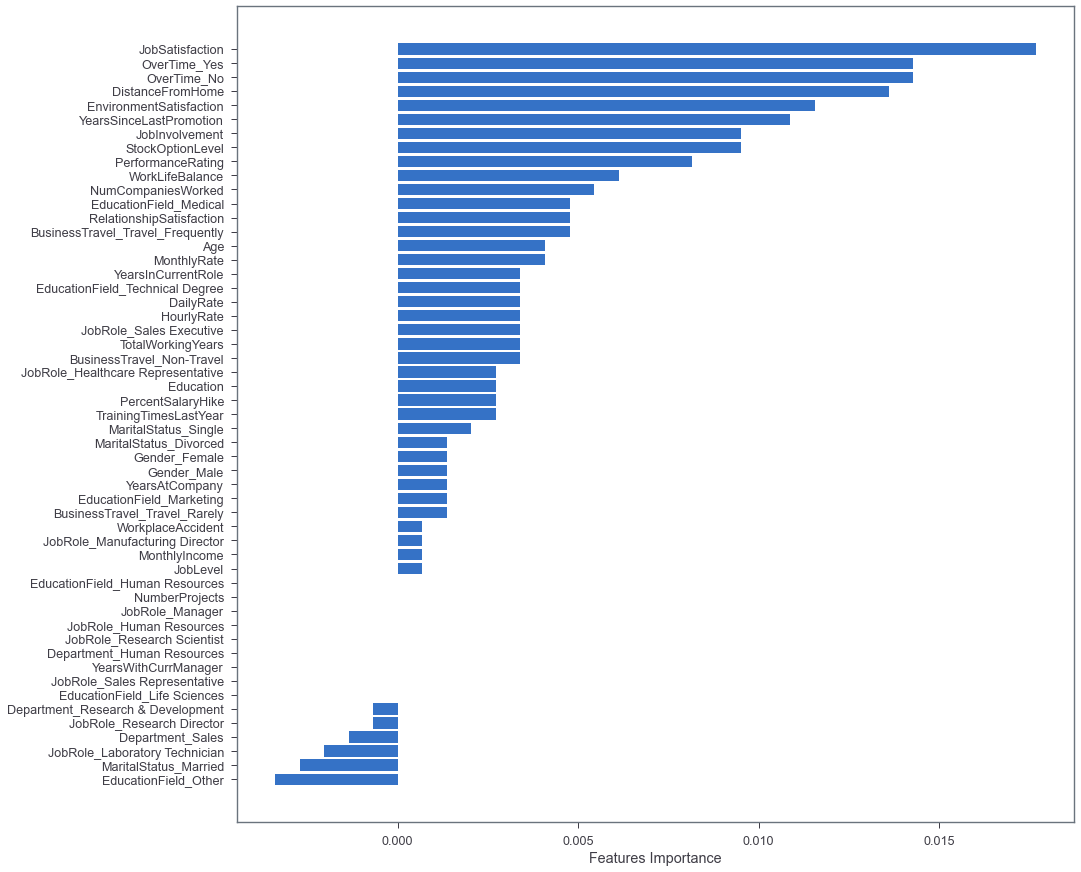

In [288]:
# List the importance of features in predicting the target variable, Attrition.

from sklearn.inspection import permutation_importance

svc_importance = permutation_importance(svc_classifier, X_test_scaled, y_test)

features = np.array(feature_names)
SVC_feat_sorted = svc_importance.importances_mean.argsort()

plt.figure(figsize=[15, 15])
plt.barh(features[SVC_feat_sorted], svc_importance.importances_mean[SVC_feat_sorted])
plt.xlabel("Features Importance")


### Test Models
- Assess classification model accuracy


In [289]:
# Spot chexk the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]
# Spot check the model by making a single prediction
print("Make a prediction using the SVM classifier from a single observation at row {} {}".format(rand_num, svc_classifier.predict(scaler.transform(single_observation))))
print("The actual value in (Attrition_Yes) the original dataframe is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the database is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the SVM classifier from a single observation at row 399 [0.]
The actual value in (Attrition_Yes) the original dataframe is 399    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the database is 399    No
Name: Attrition, dtype: object 



## Model 4: XGBoost



### Build Model



In [290]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html
from sklearn.ensemble import GradientBoostingClassifier as XGB

xgb_classifier = XGB(random_state=44)
xgb_classifier.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=44)

In [291]:
# Make the predictions
xgb_pred = xgb_classifier.predict(X_test_scaled)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [292]:
xgb_acc_score = accuracy_score(y_test,xgb_pred)
print("XGBoost Accuracy Score = {0:.5g}%".format(xgb_acc_score * 100))

XGBoost Accuracy Score = 87.755%


In [293]:
xgb_confusion_matrix = confusion_matrix(y_test, xgb_pred)
print("XGB Confusion Matrix \n {}".format(xgb_confusion_matrix))

XGB Confusion Matrix 
 [[247   5]
 [ 31  11]]


In [294]:
balanced_accuracy_score(y_test, xgb_pred)

XGB_CM = confusion_matrix(y_test, xgb_pred)

XGB_cm_df = pd.DataFrame(
    XGB_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

XGB_cm_df.head()

,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,247,5
Actual_low_risk,31,11



### Test Models
- Assess classification model accuracy
- Choose best performing model


In [295]:
# Spot chexk the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]
# Spot check the model by making a single prediction
print("Make a prediction using the LR classifier from a single observation at row {} {}".format(rand_num, xgb_classifier.predict(scaler.transform(single_observation))))
print("The actual value in (Attrition_Yes) the original dataframe is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the dataframe is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the LR classifier from a single observation at row 527 [0.]
The actual value in (Attrition_Yes) the original dataframe is 527    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the dataframe is 527    No
Name: Attrition, dtype: object 



## Model 5: Naive Bayes



### Build Model



In [296]:
# Documentation = https://scikit-learn.org/stable/modules/classes.html
from sklearn.naive_bayes import GaussianNB as GNB

In [297]:
gnb_classifier = GNB()
gnb_classifier.fit(X_train_scaled, y_train)

GaussianNB()

In [298]:
# Make the predictions
gnb_pred = gnb_classifier.predict(X_test_scaled)


### Assess classification model accuracy
- Calculate Accuracy Score 
- Calculate Confusion Matrix

In [299]:
naive_acc_score = accuracy_score(y_test,gnb_pred)
print("Naive Bayes Accuracy Score = {0:.5g}%".format(naive_acc_score * 100))

Naive Bayes Accuracy Score = 62.585%


In [300]:
gnb_confusion_matrix = confusion_matrix(y_test, gnb_pred)
print("XGB Confusion Matrix \n {}".format(gnb_confusion_matrix))

XGB Confusion Matrix 
 [[156  96]
 [ 14  28]]


In [301]:
balanced_accuracy_score(y_test, gnb_pred)

GNB_CM = confusion_matrix(y_test,gnb_pred)

gnb_cm_df = pd.DataFrame(
    GNB_CM
    , index=['Actual_high_risk', 'Actual_low_risk'], columns=['Predicted_high_risk', 'Predicted_low_risk']
)

gnb_cm_df.head()

,Predicted_high_risk,Predicted_low_risk
Actual_high_risk,156,96
Actual_low_risk,14,28


In [302]:
# Spot chexk the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]
# Spot xhexk the model by making a single prediction
print("Make a prediction using the LR classifier from a single observation at row {} {}".format(rand_num, gnb_classifier.predict(scaler.transform(single_observation))))
print("The actual value for Attrition in the original dataframe is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the database is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the LR classifier from a single observation at row 90 [0.]
The actual value for Attrition in the original dataframe is 90    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the database is 90    No
Name: Attrition, dtype: object 


## Which model is the most accurate
## We will take the most accurate model and perform hyperparameter tuning to see if we can increase model accuracy

In [303]:
print("LR Accuracy Score = {0:.5g}%".format(LR_acc_score * 100))
print("RF Accuracy Score = {0:.5g}%".format(rf_acc_score * 100))
print("XGBoost Accuracy Score = {0:.5g}%".format(xgb_acc_score * 100))
print("SVC Accuracy Score = {0:.5g}%".format(svc_acc_score * 100))
print("Naive-Bayes Accuracy Score = {0:.5g}%".format(naive_acc_score * 100))

LR Accuracy Score = 89.796%
RF Accuracy Score = 86.735%
XGBoost Accuracy Score = 87.755%
SVC Accuracy Score = 89.116%
Naive-Bayes Accuracy Score = 62.585%



### Hyper parameter tuning
- Since both Logistic Regression and SVM were very close in accuracy we will we will attempt to increase the accuracy of both using hyperparameter tuning
- There are 3 hyperparmeter tuning methods to consider
- Grid search - This is the most comprehensive - fits the model to every possible feature combination, then select the combination that has produced the best performance
- Random Search - More manual than grid search - chooses values randomly so needs to be performed multiple times
- Bayesian optimization - Works by finding the optimal hyperparameters using an optimization problem algorithm

We will stick with the Grid Search method using GridSearchCV
Since logistic regression was the most accurate, we will attempt to increase it's accuracy using hyperparameter tuning then try to tune the SVM classifier.

In [304]:
# Check which hyperparameters can be tuned in a LR classifier
LR_hp_tuned = LogisticRegression()   
LR_hp_tuned.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [305]:
# Documentation at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV
# There are many many parameters we can adjust in the tuning process, we will try a couple of approaches
# This is the first approach at tuning the LR classifier
# This takes several minutes to run so we will time it

# Get the time module
import time
start = time.perf_counter()

solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
multi_class_options = ['ovr', 'multinomial']
class_weight_options = ['None', 'balanced']
max_iterations = [100, 200, 500, 1000, 5000, 10000]

param_grid = dict(solver = solver_options, multi_class = 
multi_class_options, class_weight = class_weight_options, max_iter = max_iterations)

grid = GridSearchCV(LR_hp_tuned, param_grid, cv=8, scoring = 'accuracy', n_jobs = -1, verbose=3)
grid.fit(X_train_scaled, y_train)
grid.cv_results_

end = time.perf_counter()

# Print the execution time
print("The elapsed time to run this grid search: {} seconds".format(end-start))

Fitting 8 folds for each of 120 candidates, totalling 960 fits
The elapsed time to run this grid search: 67.1259879000063 seconds


D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
336 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py", line 1541, in fit
    sample_weight=sample_weight,
  File "D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-

In [306]:
grid_df = pd.DataFrame(grid.cv_results_)

In [307]:
grid.best_score_

0.8732993197278912

In [308]:
grid.best_estimator_

LogisticRegression(class_weight='None', multi_class='ovr', solver='newton-cg')

In [309]:
grid.best_params_

{'class_weight': 'None',
 'max_iter': 100,
 'multi_class': 'ovr',
 'solver': 'newton-cg'}

In [310]:
# The Grid Search found the best hyperparameters to use in the grid.best_params_
# In the LR classifier, specify these hyperparameters
LR_hp_tuned = LogisticRegression(class_weight='None', max_iter=100, multi_class='ovr', solver='newton-cg')

In [311]:
# fit model
LR_hp_tuned.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='None', multi_class='ovr', solver='newton-cg')

In [312]:
# Get the accuracy score
print("LR Original Accuracy Score = {0:.5g}%".format(LR_acc_score * 100))
print("LR HP Tuned Training Data Accuracy Score = {0:.5g}%".format(LR_hp_tuned.score(X_train_scaled, y_train) * 100))
print("LR HP Tuned Testing Data Accuracy Score = {0:.5g}%".format(LR_hp_tuned.score(X_test_scaled, y_test) * 100))

LR Original Accuracy Score = 89.796%
LR HP Tuned Training Data Accuracy Score = 89.711%
LR HP Tuned Testing Data Accuracy Score = 89.796%


## Trying a different set of hyperparameters logistic regression

In [313]:
# Try different hyperparameters since the first tunning attempt did not improve the LR classifier
LR_hp_tuned_2 = LogisticRegression()   
LR_hp_tuned_2.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [314]:
# The first attempt at hyperparameter tuning actually didn't help the LR algorithm
# Let's try a different set of tuning parameters

# import the time module
import time
start = time.perf_counter()

parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100, 200]},
              {'max_iter':[100, 200, 500, 1000, 5000, 10000]}]

grid_diff_parms = GridSearchCV(estimator = LogisticRegression(),  
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           n_jobs = -1,
                           cv = 8,           
                           verbose=3)

grid_diff_parms.fit(X_train_scaled, y_train)
grid_diff_parms.cv_results_

end = time.perf_counter()

# printing the execution time
print("The elapsed time to run this grid search: {} seconds".format(end-start))

Fitting 8 folds for each of 22 candidates, totalling 176 fits
The elapsed time to run this grid search: 0.9032798999978695 seconds


D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 176.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramData\Anaconda3\envs\MachineLearningEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\ProgramData\Anaconda3\envs\Machin

In [315]:
grid_diff_parms_df = pd.DataFrame(grid_diff_parms.cv_results_)

In [316]:
grid_diff_parms.best_estimator_

LogisticRegression(C=0.1)

In [317]:
grid_diff_parms.best_params_

{'C': 0.1}

In [318]:
grid_diff_parms.best_score_

0.8388139466435648

In [319]:
# create model
# By upping the max_iter parm to 10000 finally was able to get rid of warning, model performance also improved
LR_hp_tuned_2 = LogisticRegression(C=0.1)

In [320]:
# fit model
LR_hp_tuned_2.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1)

In [321]:
# Get model accuracy 

print("LR Original Accuracy Score = {0:.5g}%".format(LR_acc_score * 100))
print("LR HP Tuned Training Data Accuracy Score = {0:.5g}%".format(LR_hp_tuned_2.score(X_train_scaled, y_train) * 100))
print("LR HP Tuned Testing Data Accuracy Score = {0:.5g}%".format(LR_hp_tuned_2.score(X_test_scaled, y_test) * 100))

LR Original Accuracy Score = 89.796%
LR HP Tuned Training Data Accuracy Score = 89.541%
LR HP Tuned Testing Data Accuracy Score = 89.796%


## SVM Hyperparameter Tuning

In [322]:
# Check which hyperparameters can be used in a SVM classifier
from sklearn import svm, datasets
SVC_Tuned = svm.SVC()
SVC_Tuned.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [323]:
# import the time module
import time
start = time.perf_counter()

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[0.01, 0.1, 1, 10, 20], 'verbose':[3]}

clf = GridSearchCV(SVC_Tuned, parameters)
clf.fit(X_train_scaled, y_train)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 20, 100, 200], 'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 'penalty':['none', 'elasticnet', 'l1', 'l2'],
                        'max_iter':[100, 200, 500, 1000, 5000, 10000], 'verbose':[3]})
sorted(clf.cv_results_.keys())

end = time.perf_counter()

# Print the execution time
print("The elapsed time to run this grid search: {} seconds".format(end-start))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]The elapsed time to run this grid search: 13.21771190000436 seconds


In [324]:
svc_diff_parms_df = pd.DataFrame(clf.cv_results_)

In [325]:
clf.best_estimator_

SVC(C=0.1, kernel='linear', verbose=3)

In [326]:
clf.best_params_

{'C': 0.1, 'kernel': 'linear', 'verbose': 3}

In [327]:
clf.best_score_

0.8707392715470611

In [328]:
# Tune the model using best parameters found above by GridSearch
SVC_Tuned = SVC(kernel='linear', C=0.1, verbose=3)
SVC_Tuned.fit(X_train_scaled, y_train)

[LibSVM]

SVC(C=0.1, kernel='linear', verbose=3)

In [329]:
SVC_Tuned_pred = SVC_Tuned.predict(X_test_scaled)

In [330]:
#SVC_Tuned_acc_score = accuracy_score(y_test,SVC_Tuned_pred)
print("LR Original Accuracy Score = {0:.5g}%".format(LR_acc_score * 100))
print("SVC Original Accuracy Score = {0:.5g}%".format(svc_acc_score * 100))
print("SVC HP Tuned Training Data Accuracy Score = {0:.5g}%".format(SVC_Tuned.score(X_train_scaled, y_train) * 100))
print("SVC HP Tuned Testing Data Accuracy Score = {0:.5g}%".format(SVC_Tuned.score(X_test_scaled, y_test) * 100))

LR Original Accuracy Score = 89.796%
SVC Original Accuracy Score = 89.116%
SVC HP Tuned Training Data Accuracy Score = 89.711%
SVC HP Tuned Testing Data Accuracy Score = 89.796%


## The SVM model that the hperparameter tuning recommended was 'linear' so it's basically the logistical regression model, which is why the accuracy scores are identical. We will choose the logistical regression model for our final model. 


## Run a final test of the chosen model
- Assess classification model accuracy


In [332]:
# Spot check the model by making a single prediction
rand_num = randint(0, len(X))
# Check the model by making a prediction from an observation
single_observation = X.iloc[[rand_num]]

print("Make a prediction using the LR classifier from a single observation at row {}. Prediction is {} 0-No, 1-Yes".format(rand_num, LR_classifier.predict(scaler.transform(single_observation))))
print("The actual value of Attrition in the original dataframe is {} ".format(hr_df.iloc[[rand_num]]["Attrition_Yes"]))
print("The actual value in the databases is {} ".format(hr_df_copy.iloc[[rand_num]]["Attrition"]))

Make a prediction using the LR classifier from a single observation at row 529. Prediction is [0.] 0-No, 1-Yes
The actual value of Attrition in the original dataframe is 529    0.0
Name: Attrition_Yes, dtype: float64 
The actual value in the databases is 529    No
Name: Attrition, dtype: object 



### Finalize Model

## There are many options that can be tried with hyperparameter tuning. We experimented with a number of options but none improved the model accuracy. The final model, which gives the most accurate results is logistical regression with an accuracy of 89.8%.